# Import

In [1]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import shap

In [2]:
dname = "tcga_ov_os"

target_data = "rna"
cli_df = pd.read_csv(f"../datasets_csv/{dname}.csv")

cli_df = cli_df.drop_duplicates("case_id").drop(["slide_id", "group"], axis=1).reset_index(drop=True)
tests = pd.read_csv(f"../splits/{dname}/splits_0.csv")["test"].dropna().values
cli_df["split"] = [pd.NA] * len(cli_df)
cli_df.loc[cli_df["case_id"].isin(tests), "split"] = "test"
cli_df.loc[~cli_df["case_id"].isin(tests), "split"] = "train"

if target_data != "cli":
    target_df = pd.read_csv(f"../datasets_csv/{dname}_{target_data}.csv.zip", compression="zip")
    target_df = pd.merge(target_df, cli_df[["case_id", "split", "survival_months", "event"]], on="case_id")
else:
    target_df = cli_df

target_df.reset_index(drop=True, inplace=True)
target_df.shape, target_df.isna().any().any(), target_df["case_id"].duplicated().any(), target_df.columns.duplicated().any(), target_df.columns.isna().any()

((299, 20519), False, False, False, False)

# Preprocessing

In [3]:
# Train test split
train_df = target_df[target_df["split"] != "test"].drop(["split"], axis=1)
test_df = target_df[target_df["split"] == "test"].drop(["split"], axis=1)
train_df = train_df.drop_duplicates("case_id").reset_index(drop=True)
test_df = test_df.drop_duplicates("case_id").reset_index(drop=True)

train_ids = train_df[["case_id"]]
X_train = train_df.drop(["case_id", "event", "survival_months"], axis=1)
y_train = train_df["survival_months"]
y_train_event = train_df["event"]

test_ids = test_df[["case_id"]]
X_test = test_df.drop(["case_id", "event", "survival_months"], axis=1)
y_test = test_df["survival_months"]
y_test_event = test_df["event"]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((239, 20515), (239,), (60, 20515), (60,))

In [4]:
y_test.describe(), y_train.describe()

(count     60.000000
 mean      38.088500
 std       29.199316
 min        0.530000
 25%       18.047500
 50%       35.185000
 75%       51.760000
 max      151.910000
 Name: survival_months, dtype: float64,
 count    239.000000
 mean      36.188536
 std       29.453428
 min        0.260000
 25%       13.405000
 50%       30.620000
 75%       51.935000
 max      180.060000
 Name: survival_months, dtype: float64)

In [5]:
# Fill Missing Values with Median
indep_vars = X_train.columns
if X_train.isna().any().any():
    train_medians = X_train.median()
    for i, col in enumerate(indep_vars):
        if i % 1000 == 0:
            print(i, "/", len(indep_vars))
        if X_train[col].isna().any():
            X_train[col] = X_train[col].fillna(train_medians[col])
train_df = pd.concat([X_train, y_train_event, y_train], axis=1)
print(train_df.isna().any().any(), train_df.shape)

False (239, 20517)


In [6]:
X_train_all = X_train.copy() # for comparison

# Variance Filtering

In [7]:
print("\tBefore: ", X_train.shape)
var_sel = VarianceThreshold(0.01)
X_train = var_sel.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=indep_vars[var_sel.get_support()])
print("\tAfter variance threshold: ", X_train.shape)
removed_cols = [col for col in indep_vars if col not in X_train.columns]
print("Removed:", len(removed_cols))

	Before:  (239, 20515)
	After variance threshold:  (239, 19823)
Removed: 692


# Normalization

In [8]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_norm = sc.fit_transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns)
print(X_train_norm.min().min(), X_train_norm.max().max())
train_df = pd.concat([X_train_norm, y_train, y_train_event], axis=1)
indep_vars = X_train_norm.columns
train_df

-3.493948945191864 15.42724862054152


,133K02_rna,5T4_rna,A-C1_rna,A1BG_rna,A1BG-AS1_rna,A1CF_rna,A2M_rna,A2M-AS1_rna,A2ML1_rna,A4GNT_rna,...,ZWS1_rna,ZXDA_rna,ZXDB_rna,ZXDC_rna,ZYG11A_rna,ZYG11B_rna,ZYX_rna,ZZZ3_rna,survival_months,event
0,1.394232,-0.786470,0.474747,-0.534525,-0.610336,-0.176335,-0.190589,0.253728,-0.287863,-0.279644,...,-0.328668,-1.074578,-1.247290,-1.174853,-0.684281,-1.003132,1.662543,-1.403709,48.72,1
1,0.902435,0.302954,0.345455,-0.787991,-0.878016,0.475700,-0.704133,-0.287197,-0.294739,-0.636036,...,-0.254655,0.523765,1.733019,0.728442,0.187937,0.145525,-0.771132,-0.313282,44.28,1
2,0.342158,-0.764256,0.528649,0.696317,0.991849,-0.176335,-1.085894,-0.327404,-0.296683,-0.636036,...,1.427842,-1.689333,-1.774501,-0.382419,-0.555915,-0.190940,-0.812367,-1.507224,33.64,1
3,-0.285068,-0.541024,-0.475668,-0.968805,-1.139003,-0.176335,-0.573409,-0.507852,-0.303093,-0.236635,...,-0.700304,-1.079365,-0.745452,0.424969,-0.657137,0.520251,-0.502436,-0.369126,76.51,0
4,0.136689,-1.137404,-0.896326,-0.878123,-0.940578,-0.176335,-0.729483,1.474683,-0.301548,-0.063741,...,0.337376,1.453350,2.650976,-0.823510,-0.431062,0.684386,-0.838640,0.834480,56.50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,0.085534,-0.398718,-0.466412,-0.821402,-0.821168,-0.176335,0.071337,-0.366420,-0.313349,3.471551,...,-0.369009,1.484818,0.171561,0.435642,-0.609531,0.603441,0.003528,0.653720,20.66,1
235,-0.694197,1.695514,-0.361220,-0.246221,-0.095258,-0.176335,-0.134205,0.049327,-0.258655,-0.238160,...,-0.257264,0.968576,0.929359,0.622685,0.442273,0.403034,-1.160186,2.461785,125.66,0
236,-0.832642,-0.491653,-0.679346,-0.772347,-0.373680,-0.176335,0.388293,-0.139559,0.040240,8.216243,...,3.376461,0.692653,0.918613,2.747383,-0.291551,3.889584,0.233882,6.410945,39.65,0
237,-0.126730,-1.049488,-0.710318,-0.927654,-0.985704,-0.176335,-0.998684,-0.419891,-0.298776,-0.422585,...,0.398938,-0.058141,0.136084,1.597186,-0.670670,2.125863,-0.274415,1.327418,0.79,1


# Correlation Filtering

In [9]:
class MultiCollinearityEliminator:
    def __init__(self, df, target, threshold):
        self.df = df
        if isinstance(target, pd.DataFrame):
            self.target = target
        else:
            self.target = pd.DataFrame(target)
        self.threshold = threshold

    def createCorrMatrix(self, include_target = False):
        if (include_target == True):
            df_target = pd.concat([self.df, self.target], axis=1)
            corrMatrix = df_target.corr(method='pearson', min_periods=30).abs()
        elif (include_target == False):
            corrMatrix = self.df.corr(method='pearson', min_periods=30).abs()
        return corrMatrix

    def createCorrMatrixWithTarget(self):
        corrMatrix = self.createCorrMatrix(include_target = True)
        corrWithTarget = pd.DataFrame(corrMatrix.loc[:,self.target.columns[0]]).drop([self.target.columns[0]], axis = 0).sort_values(by = self.target.columns[0])                    
        # print(corrWithTarget, '\n')
        return corrWithTarget

    
    def createCorrelatedFeaturesList(self):
        corrMatrix = self.createCorrMatrix(include_target = False)                          
        colCorr = []
        for column in corrMatrix.columns:
            for idx, row in corrMatrix.iterrows(): 
                if (row[column]>self.threshold) and (row[column]<1):
                    
                    if (idx not in colCorr):
                        colCorr.append(idx)
                        print(idx, column, row[column], '\n')
                    if (column not in colCorr):
                        colCorr.append(column)
        # print(colCorr, '\n')
        return colCorr

    def deleteFeatures(self, colCorr):
        corrWithTarget = self.createCorrMatrixWithTarget()                                  
        for idx, row in corrWithTarget.iterrows():
            # print(idx, '\n')
            if (idx in colCorr):
                self.df = self.df.drop(idx, axis =1)
                break
        return self.df

    def autoEliminateMulticollinearity(self):
        colCorr = self.createCorrelatedFeaturesList()                                       
        while colCorr != []:
            self.df = self.deleteFeatures(colCorr)
            colCorr = self.createCorrelatedFeaturesList()                                     
        return self.df

In [10]:
# corr > 0.7 indicates multicollinearity
# https://blog.clairvoyantsoft.com/correlation-and-collinearity-how-they-can-make-or-break-a-model-9135fbe6936a#:~:text=Multicollinearity%20is%20a%20situation%20where,indicates%20the%20presence%20of%20multicollinearity.
import matplotlib.pyplot as plt

X_train = train_df[indep_vars]
corr = train_df.corr().abs()

if len(indep_vars) < 1000:
#     if target_data == "cli":
#         ticks = ['Hispanic', 'Age', 'Stage', 'Asian',
#         'Black', 'White', 'Ex Biopsy', 'Cytology',
#         'Inc Biopsy', 'Resection', 'G1', 'G2',
#         'G3', 'G4', 'Stage I', 'Stage II',
#         'Stage III', 'Stage IV', 'time', 'event']
#         corr.columns = ticks
#         corr.index = ticks
#         plt.figure(figsize=(15, 13))
#         sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

        # plt.show()
        # plt.savefig(f"./tcga_ov/figs/cli_hm{surv_type}.png")

    cor_sel = MultiCollinearityEliminator(df=X_train, target=y_train, threshold=.7)
    X_train = cor_sel.autoEliminateMulticollinearity()
    removed_cols2 = [i for i in indep_vars if i not in X_train.columns]
else:
    print((corr>=.7).sum().sum())
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    removed_cols2 = [column for column in upper.columns if any(upper[column] > .7)]
    print("Removed:", len(removed_cols2))
    X_train = X_train.drop(columns=removed_cols2, axis=1)
print("\tAfter collinearity elimination: ", X_train.shape)
train_df = pd.concat([X_train, y_train, y_train_event], axis=1)
indep_vars = X_train.columns

156597
Removed: 6195
	After collinearity elimination:  (239, 13628)


# Univariate Feature Selection

In [11]:
train_data = train_df.copy()

logrank_results = {}
sign_features = []
# Perform univariate analysis for each feature
for feature in X_train.columns:
    # Binarize or categorize the feature (e.g., by median)
    if len(X_train[feature].unique()) > 2:
        train_data["group"] = train_data[feature].apply(lambda x: x > train_data[feature].median())
    else:
        train_data["group"] = train_data[feature].apply(lambda x: x > 0)
    # Survival times and event indicators
    T = train_data['survival_months']
    E = train_data['event']

    # Compare survival distributions
    ix = train_data["group"]
    results = logrank_test(T[ix], T[~ix], event_observed_A=E[ix], event_observed_B=E[~ix])
    
    # logrank_results[feature] = str(round(results.p_value, 4))+"*" if results.p_value < 0.05 else results.p_value
    logrank_results[feature] = results.p_value
    if results.p_value < 0.05:
        sign_features.append(feature)
        # kmf = KaplanMeierFitter()
        # kmf.fit(T[ix], E[ix], label=f'{feature} high')
        # ax = kmf.plot()
        # kmf.fit(T[~ix], E[~ix], label=f'{feature} low')
        # kmf.plot(ax=ax)
        # handles, labels = ax.get_legend_handles_labels()

        # # Update labels to desired format
        # formatted_labels = [f'{feature.replace("_", " ").capitalize().replace("1.0", "II").replace("3.0", "IV")} low', 
        #                     '', 
        #                     f'{feature.replace("_", " ").capitalize().replace("1.0", "II").replace("3.0", "IV")} high', 
        #                     '']

        # # Reassign handles and labels to the legend, skipping the second and fourth items
        # plt.legend([handles[0], handles[1]], [formatted_labels[0], formatted_labels[2]])
        # plt.ylabel("S(t)", rotation=0,  fontsize=12, labelpad=15)
        # plt.xlabel("t", fontsize=12)
        # ax.text(0.75, 0.8, f'p-value = {results.p_value:.3f}', transform=ax.transAxes)
        # plt.savefig(f'./tcga_ov/figs/km_plot_{feature}_{dname}.png')

        # plt.close()
        
    # Store results
    

# Convert results to DataFrame for easier viewing
logrank_results_df = pd.DataFrame.from_dict(logrank_results, orient='index', columns=['p-value'])

print(logrank_results_df.sort_values("p-value"))
removed_cols3 = [i for i in indep_vars if i not in sign_features]
print("Removed: ", len(removed_cols3))
indep_vars = sign_features
X_train = X_train[indep_vars]
print(X_train.shape)
len(sign_features)

               p-value
FAM166B_rna   0.000008
AGFG1_rna     0.000111
EMP1_rna      0.000111
NPEPL1_rna    0.000116
ARHGEF38_rna  0.000154
...                ...
C5orf23_rna   0.999747
SIRT1_rna     0.999835
HDAC11_rna    0.999895
LEMD2_rna     0.999897
NSUN3_rna     0.999950

[13628 rows x 1 columns]
Removed:  12825
(239, 803)


803

In [12]:
print(len(removed_cols), len(removed_cols2), len(removed_cols3))
max_length = max(len(removed_cols), len(removed_cols2), len(removed_cols3))

removed_cols_padded = np.pad(removed_cols, (0, max_length - len(removed_cols)), constant_values=np.nan)
removed_cols2_padded = np.pad(removed_cols2, (0, max_length - len(removed_cols2)), constant_values=np.nan)
removed_cols3_padded = np.pad(removed_cols3, (0, max_length - len(removed_cols3)), constant_values=np.nan)

removed_df = pd.DataFrame({
    "VarThresh": removed_cols_padded,
    "CollinReduced": removed_cols2_padded,
    "Univariate": removed_cols3_padded
})
removed_df

692 6195 12825


,VarThresh,CollinReduced,Univariate
0,ACTR3BP2_rna,ABCA6_rna,133K02_rna
1,ADAM7_rna,ABCA8_rna,5T4_rna
2,AMELY_rna,ABCA9_rna,A-C1_rna
3,AOX2P_rna,ABCB1_rna,A1BG_rna
4,ASB11_rna,ABCC10_rna,A1BG-AS1_rna
...,...,...,...
12820,nan,nan,ZXDC_rna
12821,nan,nan,ZYG11A_rna
12822,nan,nan,ZYG11B_rna
12823,nan,nan,ZYX_rna


In [13]:
removed_df.to_csv("./tmp_removed.csv", index=False)

# Feature Importance

In [14]:
y = pd.concat([y_train, y_train_event], axis=1)

cph = CoxPHFitter(penalizer=.1)
cph.fit(pd.concat([X_train, y], axis=1), 'survival_months', 'event')

# Calculate SHAP values
explainer = shap.Explainer(cph.predict_partial_hazard, X_train, max_evals=2 * X_train.shape[1] + 1)
shap_values = explainer(X_train)

# Calculate mean absolute SHAP values for feature importance
feature_importance = np.abs(shap_values.values).mean(axis=0)

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importance
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
feature_importance_df

/home/ezgitwo/miniconda3/envs/torch/lib/python3.9/site-packages/lifelines/utils/__init__.py:992: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warning_text, ConvergenceWarning)
/home/ezgitwo/miniconda3/envs/torch/lib/python3.9/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column CDX4_rna have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'CDX4_rna'].var())
>>> print(df.loc[~events, 'CDX4_rna'].var())

A very low variance means that the column CDX4_rna completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), Convergence

,feature,importance
0,MDM_rna,8.725247e+12
1,TMBIM1_rna,3.672779e+12
2,ARL1_rna,3.218001e+12
3,DIO1_rna,3.164099e+12
4,DMBT1L1_rna,2.576175e+12
...,...,...
798,OFD1_rna,1.062524e+09
799,LINC00475_rna,1.047704e+09
800,SERPINA10_rna,8.364929e+08
801,CCDC30_rna,6.789323e+08


In [15]:
# feature_importance_df.to_csv("./tmp_feat.csv", index=False)

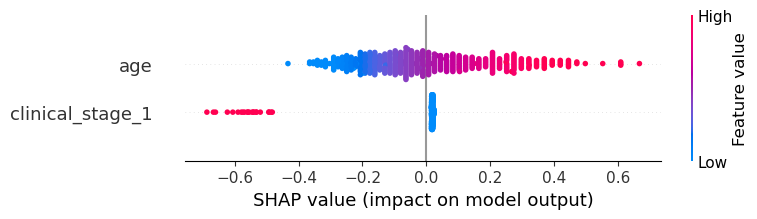

In [16]:
# Plot the SHAP summary plot (optional)
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

# Cross Validation

In [16]:
def cross_validate_survival_model(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    c_index_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Combine features and target for CoxPHFitter
        train_data = pd.concat([X_train, y_train], axis=1)
        test_data = pd.concat([X_test, y_test], axis=1)
        
        # Fit the Cox Proportional Hazards model
        cph = CoxPHFitter(penalizer=0.1)
        cph.fit(train_data, 'survival_months', 'event')
        
        # Predict partial hazard for test set
        partial_hazard = cph.predict_partial_hazard(test_data)
        
        # Calculate concordance index
        c_index = concordance_index(test_data['survival_months'], -partial_hazard, test_data['event'])
        c_index_scores.append(c_index)
    
    return np.mean(c_index_scores), np.std(c_index_scores)


In [ ]:
results = []
print_every = 50 if X_train.shape[1] > 100 else 10
for i in range(1, X_train.shape[1]+1):
    selected_features = feature_importance_df.loc[:i, "feature"].values
    X = X_train[selected_features]
    y = pd.concat([y_train, y_train_event], axis=1)

    # Perform cross-validation
    mean_c_index, std_c_index = cross_validate_survival_model(X, y)
    results.append((i, mean_c_index, std_c_index))

    if i % print_every == 0:
        print(f'Number of features: {i} | Cross-validated C-index: {mean_c_index:.4f} ± {std_c_index:.4f}')

In [21]:
# pd.DataFrame(results, columns=["Number of features", "Mean C-index", "Std C-index"]).to_csv("./tmp_results.csv", index=False)

In [26]:
# Define your feature set and target
X = X_train_all.drop(removed_cols+removed_cols2, axis=1)  # Use selected features
y = pd.concat([y_train, y_train_event], axis=1)

# Perform cross-validation
mean_c_index_all, std_c_index_all = cross_validate_survival_model(X, y)
print(f'Cross-validated C-index: {mean_c_index_all:.4f} ± {std_c_index_all:.4f}')
results.append([X.shape[1], mean_c_index_all, std_c_index_all])

Cross-validated C-index: 0.6233 ± 0.0135


In [18]:
results_df = pd.DataFrame(results, columns=["Number of features", "Mean C-index", "Std C-index"])
results_df

,Number of features,Mean C-index,Std C-index
0,1,0.556544,0.062655
1,2,0.570777,0.074950
2,3,0.564158,0.069806
3,4,0.587201,0.082038
4,5,0.619152,0.072211
...,...,...,...
591,592,0.684886,0.037104
592,593,0.683260,0.031412
593,594,0.682390,0.032428
594,595,0.681986,0.034674


In [19]:
results_df[results_df["Mean C-index"] == results_df["Mean C-index"].max()]

,Number of features,Mean C-index,Std C-index
170,171,0.764974,0.041249


# Save

In [20]:
with pd.ExcelWriter(f'./tcga_ov/{dname}_fs_{target_data}.xlsx') as writer:
        removed_df.to_excel(writer, sheet_name="Filtering")
        logrank_results_df.to_excel(writer, sheet_name="LogRank")
        feature_importance_df.to_excel(writer, sheet_name="SHAP")
        results_df.to_excel(writer, sheet_name="CV")

In [10]:
with pd.ExcelFile(f'./tcga_ov/{dname}_fs_{target_data}.xlsx') as ef:
        removed_df = pd.read_excel(ef, sheet_name="Filtering")
        feature_importance_df = pd.read_excel(ef, sheet_name="SHAP")
remove_list = np.unique(list(removed_df["VarThresh"].values) + list(removed_df["CollinReduced"].values) + list(removed_df["Univariate"].values))
print(len(indep_vars), len(remove_list))
indep_vars = [x for x in indep_vars if x not in remove_list]
print(len(indep_vars))
feature_importance_df

227 14147
227


,Unnamed: 0,feature,importance
0,0,SPINK7_dna,0.516942
1,1,RAD54B_dna,0.510840
2,2,PRR18_dna,0.443618
3,3,C17orf88_dna,0.432758
4,4,LOXHD1_dna,0.382277
...,...,...,...
222,222,PGRMC1_dna,0.002913
223,223,NCCRP1_dna,0.002604
224,224,C3orf62_dna,0.002245
225,225,PSKH2_dna,0.000724
